In [33]:
# importing necessary libraries
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
# nltk.download('punkt')
import openai
from time import time,sleep

## 1) Text Preprocessing

In [35]:
# opens the file
filename = 'subtitle'
file = open('conv_dataset/'+filename+'.txt','r',encoding='utf-8-sig')
# print(file.read())

# removes leading and trailing white spaces
f = file.read().strip()

# adds a fullstop at the end of sentences
f = re.sub(r'\n\n\n','. ',f)

# removing additional fullstops
f = re.sub('\\.\\.','.',f)

# replaces newline characters with white space
f = f.replace("\n", " ")

# truncating Transcript word in the beginning of the file
# f = f[11:]

# removing time stamps
f = re.sub(r'\d{2}:\d{2}:\d{2} -','',f)

# removes additional whitespaces
f = re.sub(r' +', ' ', f)
# f = f[1:]

# removes consecutive repeated words
while re.search(r'\b(.+)(\s+\1\b)+', f):
    f = re.sub(r'\b(.+)(\s+\1\b)+', r'\1', f)

# print(f)

# saves file with speaker names included
f_with_names = open('preprocessed_dataset/'+filename+'_prep_name.txt','w')
f_with_names.write(f)
f_with_names.close()

# removing speaker names
s = re.sub(r'[A-Za-z\s]*\:','',f)
print(s)

# saves file without speaker names included
f_without_names = open('preprocessed_dataset/'+filename+'_prep_no_name.txt','w')
f_without_names.write(s)
f_without_names.close()


# filler words to be removed
# remove special characters
# lemmatization
# convert stop words to meaninful words

As part of this course by deeplearning.ai, I hope to not just teach you the technical ideas in deep learning, but also introduce you to some of the people, some of the heroes in deep learning. The people that invented so many of these ideas that you learn about in this course or in this specialization. In these videos, I hope to also ask these leaders of deep learning to give you career advice for how you can break into deep learning, for how you can do research or find a job in deep learning. As the first of this interview series, I am delighted to present to you an interview with Geoffrey Hinton. Welcome Geoff, and thank you for doing this interview with deeplearning.ai. Thank you for inviting me. I think that at this point you more than anyone else on this planet has invented so many of the ideas behind deep learning. And a lot of people have been calling you the godfather of deep learning. Although it wasn't until we were chatting a few minutes ago, until I realized you think I'm t

In [55]:
# helper for trying regex expressions
# patt = re.compile(r'[A-Za-z\s]*\:')
# matches = patt.finditer(f)
# for match in matches:
#     print(match)

## 2) Text Visualization

In [36]:
print("Total number of words:",len(list(s.split(" "))))

Total number of words: 6584


In [37]:
print("Total number of unique words:",len(set(s.split(" "))))

Total number of unique words: 1564


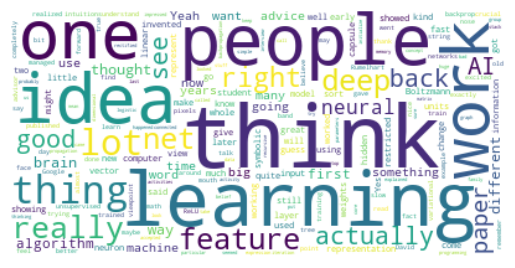

In [38]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(s)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3) Summarization

In [40]:
# tokenizer
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

In [41]:
# converts file content into sentence tokens
sentences = nltk.sent_tokenize(s)

In [42]:
print("No. of sentences : ",len(sentences))
print("Max no. of tokens model can parse : ",tokenizer.model_max_length)
print("Max no. of tokens in a sentence : ",max([len(tokenizer.tokenize(sentence)) for sentence in sentences]))
print("Total no. of tokens in the entire text : ",sum([len(tokenizer.tokenize(sentence)) for sentence in sentences]))

No. of sentences :  382
Max no. of tokens model can parse :  1024
Max no. of tokens in a sentence :  49
Total no. of tokens in the entire text :  7857


### Chunking

In [46]:
length = 0
chunk = ""
chunks = []
count = -1

for sentence in sentences:
    count += 1
    combined_length = len(tokenizer.tokenize(sentence))+length
    
    if combined_length <= tokenizer.max_len_single_sentence:
        chunk += sentence+" "
        length = combined_length
        
        if count == len(sentences)-1:
            chunks.append(chunk.strip())
    
    else:
        chunks.append(chunk.strip())
        length = 0
        chunk = ""
        chunk += sentence+" "
        length = len(tokenizer.tokenize(sentence))

In [47]:
print("No. of chunks : ",len(chunks))
print("No. of tokens in each chunk : ",[len(tokenizer.tokenize(c)) for c in chunks])

No. of chunks :  8
No. of tokens in each chunk :  [1012, 1004, 997, 1006, 1012, 1021, 1016, 786]


In [48]:
# first chunk
chunks[0]

"As part of this course by deeplearning.ai, I hope to not just teach you the technical ideas in deep learning, but also introduce you to some of the people, some of the heroes in deep learning. The people that invented so many of these ideas that you learn about in this course or in this specialization. In these videos, I hope to also ask these leaders of deep learning to give you career advice for how you can break into deep learning, for how you can do research or find a job in deep learning. As the first of this interview series, I am delighted to present to you an interview with Geoffrey Hinton. Welcome Geoff, and thank you for doing this interview with deeplearning.ai. Thank you for inviting me. I think that at this point you more than anyone else on this planet has invented so many of the ideas behind deep learning. And a lot of people have been calling you the godfather of deep learning. Although it wasn't until we were chatting a few minutes ago, until I realized you think I'm 

### Extractive Summarization (using BERT)

In [49]:
# importing model
from summarizer.sbert import SBertSummarizer

In [50]:
result = []
for c in chunks:
    model = SBertSummarizer('paraphrase-MiniLM-L6-v2')
    res = model(c, num_sentences=10)
    result.append(res)

ext_summary = " ".join(result)
print(ext_summary)

As part of this course by deeplearning.ai, I hope to not just teach you the technical ideas in deep learning, but also introduce you to some of the people, some of the heroes in deep learning. Welcome Geoff, and thank you for doing this interview with deeplearning.ai. I think that at this point you more than anyone else on this planet has invented so many of the ideas behind deep learning. And he explained that in a hologram you can chop off half of it, and you still get the whole picture. So that's what first got me interested in how does the brain store memories. I think when I was at Cambridge, I was the only undergraduate doing physiology and physics. And in psychology they had very, very simple theories, and it seemed to me it was sort of hopelessly inadequate to explaining what the brain was doing. So when I arrived he thought I was kind of doing this old fashioned stuff, and I ought to start on symbolic AI. And I went to California, and everything was different there. Paul Werbo

### Abstractive Summarization (using GPT 3)

In [51]:
openai.api_key = "YOUR KEY"

In [52]:
def gpt3_completion(prompt, engine='text-davinci-002', temp=0.6, top_p=1.0, tokens=1000, freq_pen=0.25, pres_pen=0.0):
    max_retry = 5
    retry = 0
    while True:
        try:
            response = openai.Completion.create(engine=engine,prompt=prompt,temperature=temp,max_tokens=tokens,top_p=top_p,frequency_penalty=freq_pen,presence_penalty=pres_pen)
            
            text = response['choices'][0]['text'].strip()
            text = re.sub('\s+', ' ', text)
            return text
        except Exception as oops:
            retry += 1
            if retry >= max_retry:
                return "GPT3 error: %s" % oops
            print('Error communicating with OpenAI:', oops)
            sleep(1)

In [53]:
def open_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

In [ ]:
# chunks summary
for chunk in chunks:
    prompt = open_file('prompt1.txt').replace('<<SUMMARY>>', chunk)
    prompt = prompt.encode(encoding='ASCII', errors='ignore').decode()
    summary = gpt3_completion(prompt)
    print(summary+"\n\n")

In [55]:
# extractive to abstractive summary
prompt = open_file('prompt1.txt').replace('<<SUMMARY>>', ext_summary)
prompt = prompt.encode(encoding='ASCII', errors='ignore').decode()
summary = gpt3_completion(prompt)
print(summary)

Geoffrey Hinton is a British computer scientist, cognitive psychologist, and neuroscientist most known for his work on artificial neural networks. In this conversation with deeplearning.ai, Hinton discusses his early work on artificial neural networks and how his thinking about AI has changed over the years. He also talks about some of the current challenges in AI, including unsupervised learning and the need for more researchers trained in deep learning.
